# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting. We've implemented this in `libs/unet.py` module, and we will review it here.

In [1]:
import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

from libs.util import random_mask
from libs.pconv_model import PConvUnet

# Settings
MAX_BATCH_SIZE = 10

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Testing out on single image

filename data/train/sample_1.jpg
data/sample_1.jpg
Shape of image is: (512, 512, 3)
filename data/train/sample_3.jpg
data/sample_3.jpg
Shape of image is: (512, 512, 3)
filename data/train/sample_2.jpg
data/sample_2.jpg
Shape of image is: (512, 512, 3)
filename data/train/sample_4.jpg
data/sample_4.jpg
Shape of image is: (512, 512, 3)


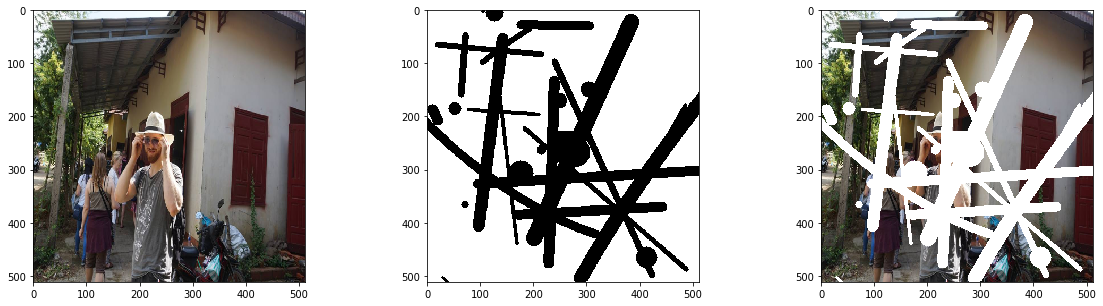

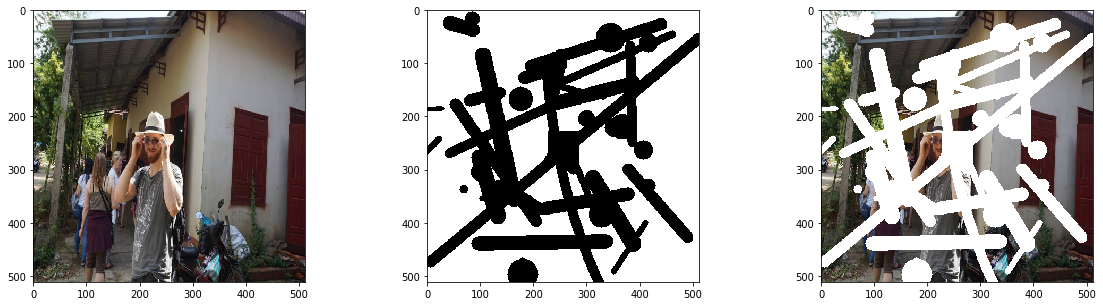

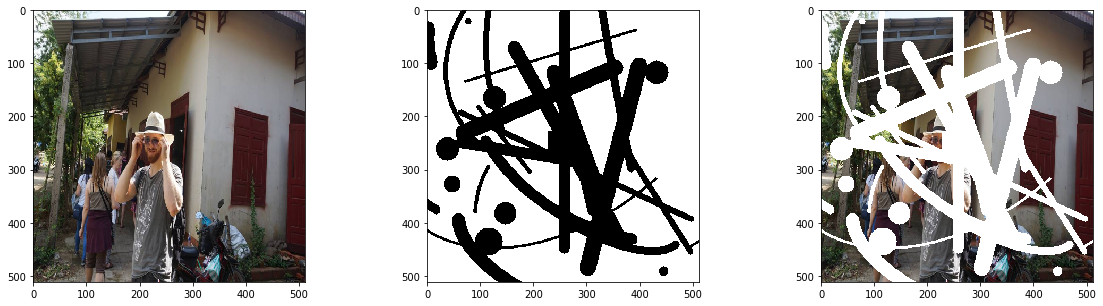

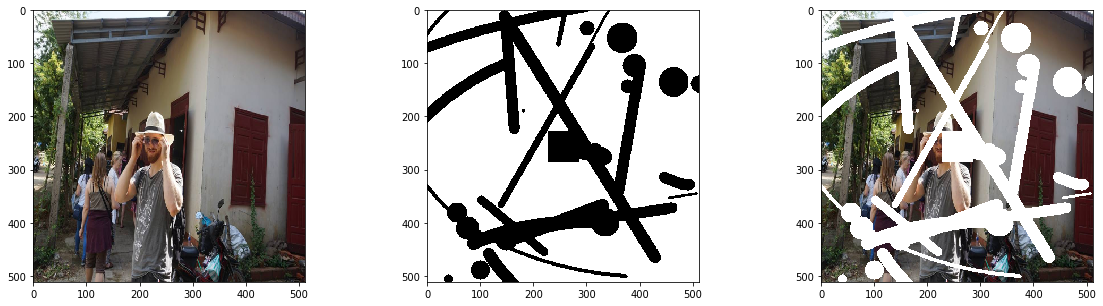

In [2]:
from PIL import Image
import glob
import os
image_list = []
for filename in glob.glob('data/train/*.jpg'): #assuming jpg
    # Load image
    print(f"filename",filename)
    filename2 = os.path.join('data/',os.path.basename(filename))
    print(filename2)
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 512)) / 255
    image_list.append(img)
    shape = img.shape
    print(f"Shape of image is: {shape}")

# center mask
mask0 = np.ones(img.shape)
for ix in range(mask0.shape[0]):
    for iy in range(mask0.shape[0]):
        if (ix>226 and ix <286 and iy>226 and iy <286):
            mask0[ix][iy]=0

# Load mask
mask = np.stack([random_mask(image_list[0].shape[0], image_list[0].shape[1]) for _ in range(len(image_list))], axis=0)
mask_def = np.stack([mask0 for _ in range(len(image_list))], axis=0)


# Image + mask
masked_img = np.stack([image_list[i] for i in range(len(image_list))],axis=0)
ori_img = deepcopy(masked_img)
mask[mask_def==0]=0
masked_img[mask==0] = 1

# Show side by side
for i in range(len(image_list)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(ori_img[i])
    axes[1].imshow(mask[i]*255)
    axes[2].imshow(masked_img[i])
    plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us. The generator is based off the ImageDataGenerator from keras.processing, which allows us to do all kinds of autmentation more easily. 

(4, 512, 512, 3)


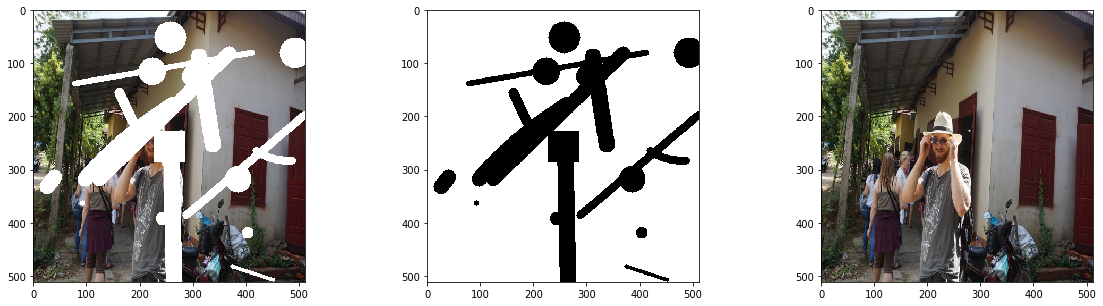

In [3]:
class DataGenerator(ImageDataGenerator):
    def flow(self, x,y, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            (ori,mask0),ground = next(super().flow(x,y, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            mask[mask0==0]=0

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask,mask0], ground        

# Create datagen
datagen = DataGenerator(  
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=True
)


                
# Create generator from numpy arrays

generator = datagen.flow(x=(ori_img,mask_def),y=ori_img, batch_size=4)

# Get samples & Display them
(masked, mask,mask00), ori = next(generator)

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[0,:,:,:])
axes[1].imshow(mask[0,:,:,:]*255)
axes[2].imshow(ori_img[0,:,:,:])
print(masked.shape)

## Training classifier on single image

In [4]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask,mask00])

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')                
        plt.show()

In [43]:
from keras.callbacks import TensorBoard
model = PConvUnet(weight_filepath='data/logs/')
model.load("data/logs/5_weights_2019-02-18-19-08-52.h5", train_bn=True)
model.fit(
    generator, 
    steps_per_epoch=10,
    epochs=5,
    plot_callback=plot_callback,    
    callbacks=[
        TensorBoard(log_dir='../data/logs/fine_tuning', write_graph=True)
    ]    
)

OSError: Unable to open file (unable to open file: name = 'data/logs/5_weights_2019-02-18-19-08-52.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [45]:
model.load("data/logs/4_weights_2019-02-18-19-26-42.h5", train_bn=False)

In [46]:
def plot_images(images, s=5):
    _, axes = plt.subplots(1, len(images), figsize=(s*len(images), s))
    if len(images) == 1:
        axes = [axes]
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.show()

In [47]:
pred=model.predict([masked, mask,mask00], verbose=0)

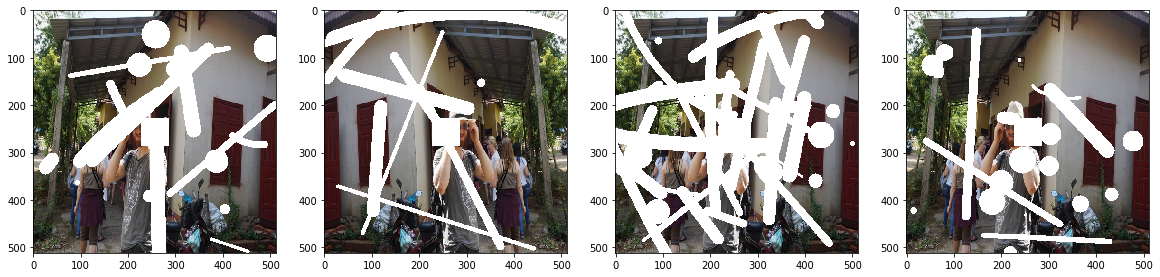

In [48]:
plot_images(masked)

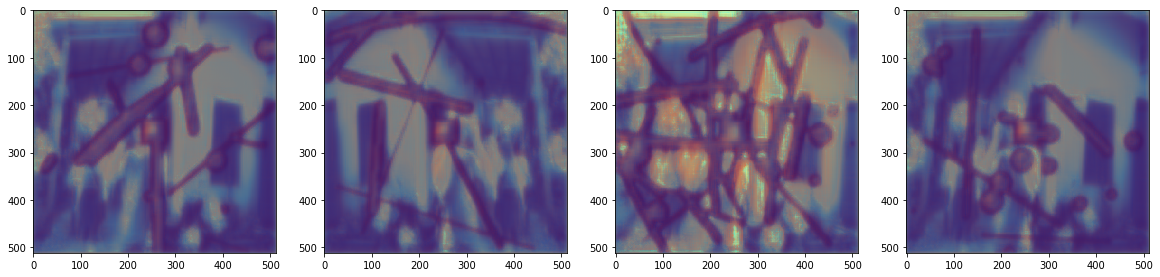

In [49]:
plot_images(pred)

In [55]:
# Run prediction quickly
img_1 = cv2.imread('data/train/sample_1.jpg')
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_1 = cv2.resize(img_1, (1024, 1024)) / 255
mask_1 = np.ones(img_1.shape)
mask_0 = np.ones(img_1.shape)
pred = model.scan_predict((img_1, mask_1,mask_0))

In [56]:
print(mask_1.shape)

(1024, 1024, 3)


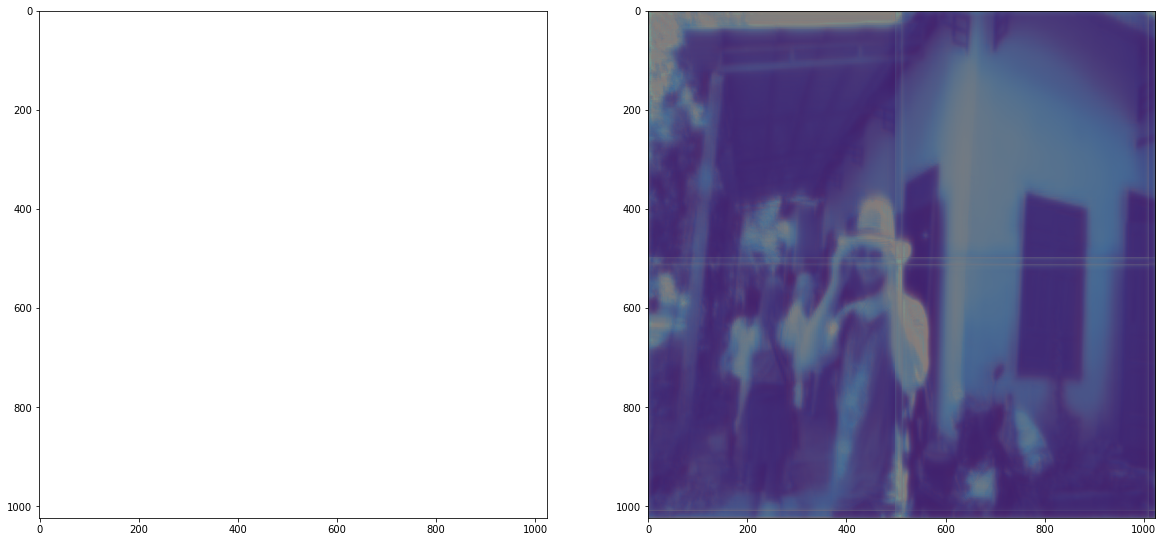

In [57]:
# Show result
plot_images([mask_1, pred], s=10)